## Imports

In [1]:
%matplotlib inline
from utils import *
from plotting import *
from models import *

## Load Dataset (e.g., Animal-AI_v3)

In [2]:
dataset, pose = load_dataset('dataset_animalai3', file_format='.npy', load_pose=True, pose_filename='pose.npy')

In [3]:
position = pose[:,:2]
orientation = pose[:,2]

In [4]:
print(dataset.shape, pose.shape)

(20000, 84, 84, 3) (20000, 3)


### Intrinsic dimensionality

In [5]:
D = intrinsic_dimensionality(dataset, method='MLE')

In [6]:
print(D)

15.133035401257239


In [5]:
D = intrinsic_dimensionality(dataset, method='TwoNN')

In [6]:
print(D)

10.013482668895078


In [7]:
D = intrinsic_dimensionality(dataset, method='FisherS')

In [8]:
print(D)

5.488885536636774


In [9]:
D = intrinsic_dimensionality(dataset, method='PCA')

In [10]:
print(D)

19


### Occupancy map

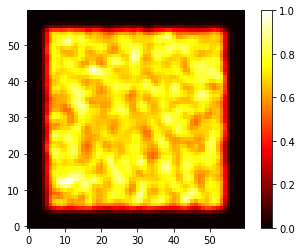

In [5]:
occ_map = occupancy_map(position, filter_width=1, padding=True, n_bins_padding=5)
plt.imshow(occ_map, cmap='hot', origin='lower')
plt.colorbar()

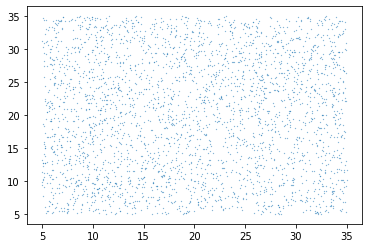

In [6]:
plt.scatter(position[:3000,0], position[:3000,1], s=.05)

## Autoencoder network

In [11]:
model = Conv_AE(n_hidden=100)

In [8]:
dataset = dataset[:10000, :]
position = position[:10000, :]
orientation = orientation[:10000]

In [9]:
train_loader = create_dataloader(dataset, batch_size=64)

In [69]:
history, _ = train_autoencoder(model, train_loader, num_epochs=100, learning_rate=1e-3, device='cuda', L2_weight_decay=0, L1_lambda=1e-5, orth_alpha=5e-1, soft_sparsity_weight=0, model_type='AE')

Epoch 68/100, Loss: 0.0120: 100%|████████████████████████████████████████████████████| 157/157 [00:03<00:00, 44.03it/s]


Epoch 100/100, Loss: 0.0123: 100%|███████████████████████████████████████████████████| 157/157 [00:03<00:00, 48.26it/s]


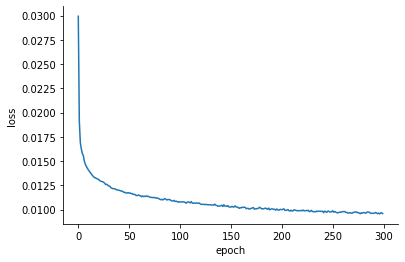

In [13]:
plt.plot(history)
plt.xlabel('epoch')
plt.ylabel('loss')
sb.despine()
plt.show()

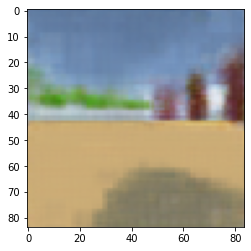

In [53]:
plt.imshow(predict(dataset[12], model))

In [70]:
embeddings = get_latent_vectors(dataset, model)

In [71]:
#np.save('embeddings_animalai_autoencoder.npy', embeddings)

In [72]:
#embeddings = np.load('embeddings.npy')

## Intrinsic dimensionality of population activity

In [73]:
D = intrinsic_dimensionality(embeddings, method='PCA')

In [74]:
print(D)

52


## Rate maps of single units

In [75]:
all_ratemaps = ratemaps(embeddings, position, n_bins=50, filter_width=3, occupancy_map=[], padding=True, n_bins_padding=5)

In [21]:
plot_ratemaps(all_ratemaps)

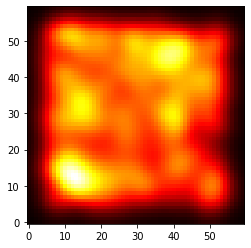

In [28]:
plt.imshow(np.sum(all_ratemaps, axis=0), cmap='hot', origin='lower')

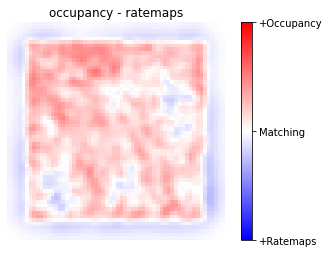

In [29]:
overall_ratemap = np.sum(all_ratemaps, axis=0).T
overall_ratemap = overall_ratemap/overall_ratemap.max()
map_diffs = occ_map - overall_ratemap
#min_ = np.min([map_diffs.min(), -map_diffs.max()])
#max_ = np.max([map_diffs.max(), -map_diffs.min()])
plt.imshow(map_diffs, cmap='bwr', origin='lower', vmin=-1, vmax=1)
plt.title('occupancy - ratemaps')
plt.axis('off')
cbar = plt.colorbar(ticks=[-1,0,1])
cbar.ax.set_yticklabels(['+Ratemaps', 'Matching', '+Occupancy']) 
plt.show()

In [30]:
degree_of_matching = np.round( np.sum(np.power(map_diffs, 2)) / np.count_nonzero(occ_map), 3)
print('MSE: ' + str(degree_of_matching))

MSE: 0.034


## Population sparseness

In [22]:
all_ratemaps_thres = np.copy(all_ratemaps)
all_ratemaps_thres[all_ratemaps_thres<0.2] = 0
all_ratemaps_thres[all_ratemaps_thres>=0.2] = 1

In [23]:
all_ratemaps_thres_avg = np.mean(all_ratemaps_thres, axis=0)

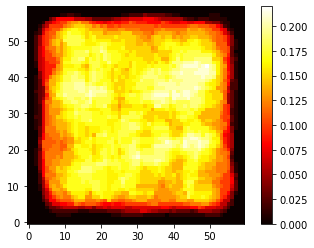

In [24]:
plt.imshow(all_ratemaps_thres_avg, origin='lower', cmap='hot')
plt.colorbar()

In [25]:
pop_sparseness = np.mean(all_ratemaps_thres_avg)

In [26]:
print(pop_sparseness)

0.11562777777777777


## Place field distribution

In [27]:
n_fields, centroids, sizes = stats_place_fields(all_ratemaps, peak_as_centroid=True, min_pix_cluster=0.05, 
                                                max_pix_cluster=0.5, active_pixels_threshold=0.2)

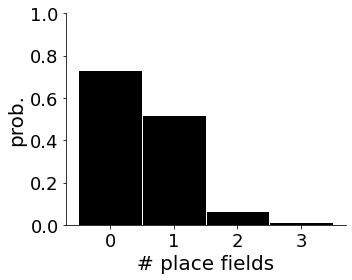

In [28]:
plot_place_field_hist(n_fields)

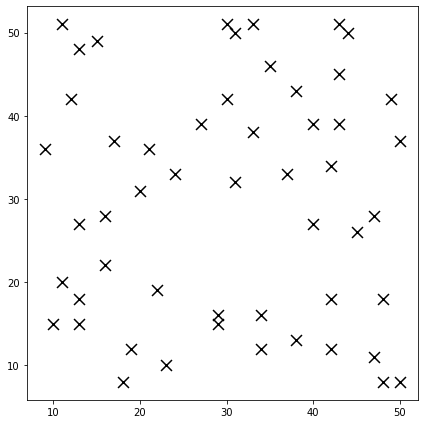

In [29]:
plt.figure(figsize=(6,6))

#plt.imshow(np.sum(all_ratemaps[:-1], axis=0), cmap='hot', origin='lower')
plt.scatter(centroids[:,0], centroids[:,1], color='black', marker='x', s=120)
#plt.axis('off')

plt.tight_layout()
plt.show()

In [30]:
print('Tiling homogeneity: ' + str(homogeneity_2Dtiling(centroids)))

Tiling homogeneity: 0.7688589858048038


## Spatial information

In [31]:
SI = spatial_information(all_ratemaps, occ_map)

In [32]:
print(np.mean(SI))

1.9641277238515125


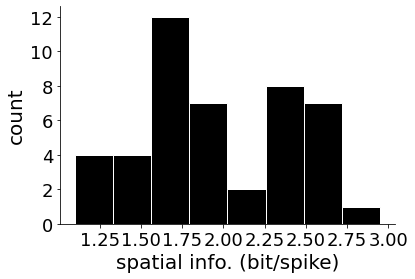

In [33]:
plt.hist(SI, color='black', bins=8, edgecolor='white')
plt.xlabel('spatial info. (bit/spike)', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
sb.despine()
plt.show()

## Check whether centric place fields are also larger, i.e., if place fields close to the wall are smaller (and also more numerous) --> https://www.sciencedirect.com/science/article/pii/S0960982222010089 

In [34]:
dists_to_wall = dist_to_walls(centroids, occ_map)

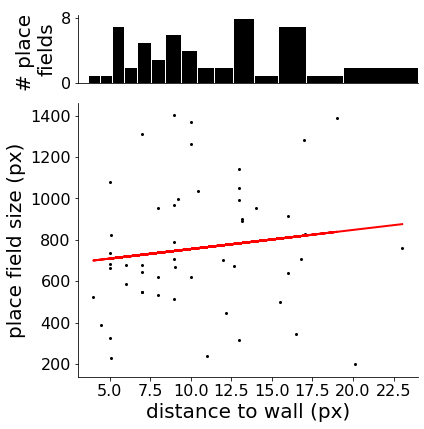

In [35]:
plot_distance_to_wall(dists_to_wall, sizes, norm_area=True)

## Check hyperbolic geometry, i.e., exponential distribution of field sizes, as in: https://www.nature.com/articles/s41593-022-01212-4 

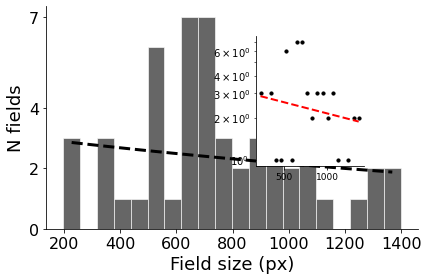

In [36]:
plot_hyperbolic_geometry(sizes, bin_width=60)

## Linear decoding of position

In [37]:
lin_score, baseline_score = linear_decoding_score(embeddings, position, n_baseline=100)

In [38]:
print('Linear decoder score: ' + str(lin_score))
print('Baseline avg.: ' + str(baseline_score[0]))

Linear decoder score: 0.5294743052845932
Baseline avg.: 0.01003753565483843


## Correlation between image distance and latent vector distance

In [ ]:
from scipy.stats import spearmanr

In [ ]:
n_exp = 100000

spatial_pos_dist = []
latent_vec_dist = []
for i in range(n_exp):
    ind_1, ind_2 = np.random.choice(np.arange(dataset.shape[0]), 2, replace=False)
    spatial_pos_dist.append( euclidean_distance(dataset[ind_1], dataset[ind_2]) )
    latent_vec_dist.append( euclidean_distance(embeddings[ind_1], embeddings[ind_2]) )

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(spatial_pos_dist, latent_vec_dist, s=.05, color='black')
m,b = np.polyfit(spatial_pos_dist, latent_vec_dist, 1)
plt.plot(spatial_pos_dist, m*np.array(spatial_pos_dist)+b, linestyle='--', color='r', linewidth=1)
#plt.title('corr_coef='+str(np.corrcoef( spatial_pos_dist, latent_vec_dist )[0][1].round(2)))
plt.title('corr_coef='+str(spearmanr( spatial_pos_dist, latent_vec_dist ).correlation.round(2)))
plt.ylabel('latent distance', fontsize=20)
plt.xlabel('image distance', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sb.despine()
plt.show()

## Head direction cells

In [39]:
all_polarmaps = polarmaps(clean_embeddings(embeddings), orientation)

In [40]:
plot_polarmaps(all_polarmaps, n_cells_plot=30)

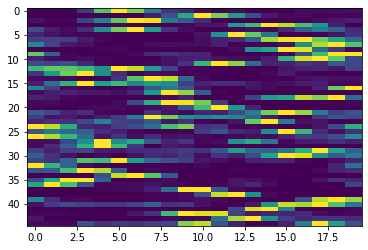

In [41]:
plt.imshow(all_polarmaps, aspect='auto', interpolation=None)

## Single unit contribution (ablation exp.)

In [ ]:
single_cell_lin_scores = []
for i in range(embeddings.shape[1]):
    ablated_embed = np.delete(embeddings, i, axis=1)
    score, _ = linear_decoding_score(ablated_embed, position, n_baseline=1)
    single_cell_lin_scores.append(score)
score_full, _ = linear_decoding_score(embeddings, position, n_baseline=1)
single_cell_contribs = score_full - np.array(single_cell_lin_scores)

In [ ]:
plt.figure(figsize=(16,4))
n_active = embeddings.shape[1]
plt.bar(np.arange(1, n_active+1), single_cell_contribs, color='black', alpha=1, width=1)
plt.xlabel('Cell #', fontsize=20)
plt.ylabel('Linear decoding contrib.', fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(np.linspace(1, n_active, n_active+1, dtype=int), np.linspace(1, n_active, n_active+1, dtype=int), fontsize=18)
#plt.ylim(0,1)
sb.despine()
plt.show()

## Population coding (ablation exp.)

In [ ]:
n_exp = 10
pop_lin_scores = np.zeros((embeddings.shape[1], n_exp))
for i in range(embeddings.shape[1]):
    print(i)
    for j in range(n_exp):
        exclude = np.random.choice(np.arange(n_active), i, replace=False) 
        ablated_embed = np.delete(embeddings, exclude, axis=1)
        score, _ = linear_decoding_score(ablated_embed, position, n_baseline=1)
        pop_lin_scores[i,j] = score

In [ ]:
mean_pop_lin_scores = np.mean(pop_lin_scores, axis=1)
std_pop_lin_scores = np.std(pop_lin_scores, axis=1)

In [ ]:
plt.errorbar(np.arange(n_active), mean_pop_lin_scores, yerr=std_pop_lin_scores, color='black')
plt.ylabel('lin. reg. score')
plt.xlabel('# of cells removed')
sb.despine()
plt.show()

## Control condition: shuffled hashes (permutation test)

In [ ]:
embeddings_shuffled = shuffle_2D_matrix(np.copy(embeddings))

In [ ]:
ratemaps_embeddings_shuffled = ratemaps(embeddings_shuffled, position, n_bins=50, filter_width=3)

In [ ]:
plot_ratemaps(ratemaps_hashing_shuffled)

In [ ]:
n_fields_shuffled, centroids_shuffled, sizes_shuffled = stats_place_fields(ratemaps_hashing_shuffled)

In [ ]:
plot_place_field_hist(n_fields_shuffled)